# Comparison of Uplift modeling packages

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklift.models import SoloModel, ClassTransformation, TwoModels
from pyuplift.transformation import Lai, Kane, Jaskowski, Pessimistic, Reflective

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, auuc_score

import warnings
warnings.simplefilter("ignore", UserWarning)
from datasets import HillstromDataset

data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1, frac=0.7)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [20]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_CTS = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='KL')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_KL = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='ED')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_ED = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='Chi')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_Chi = uplift_model.predict(X=X_test)

In [21]:
### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

In [22]:
### sklift

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

## Visualization

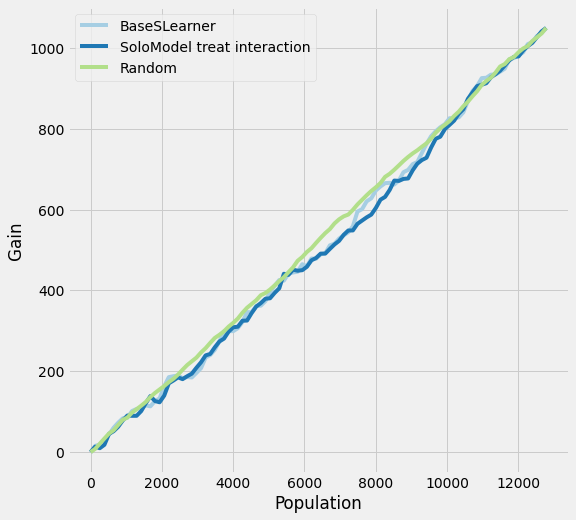

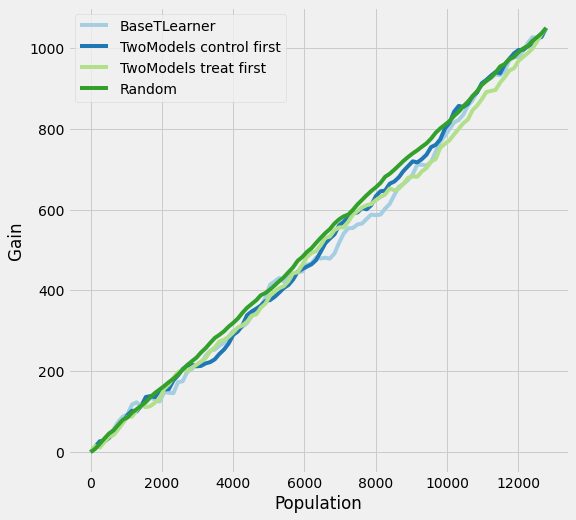

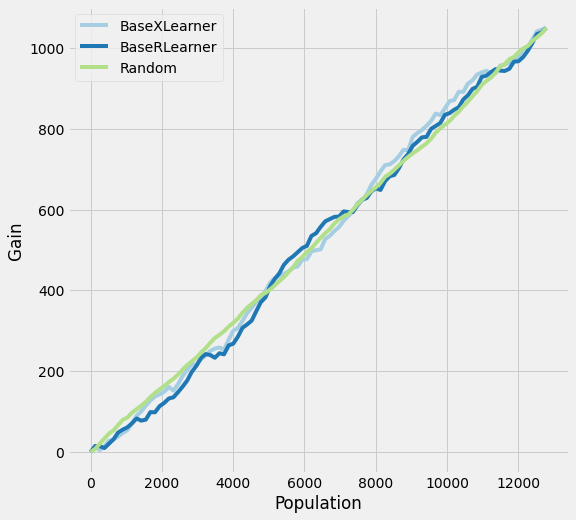

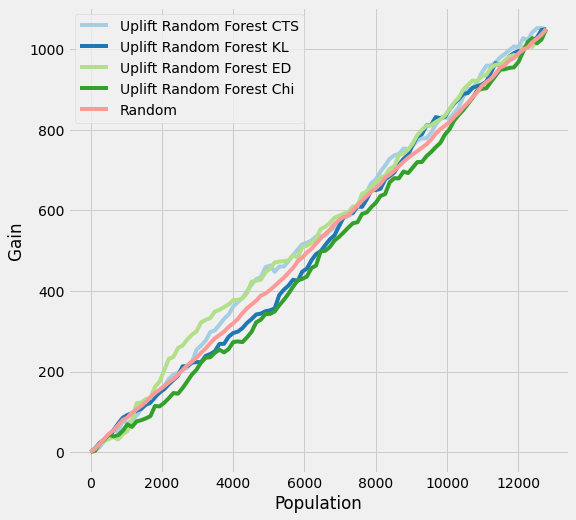

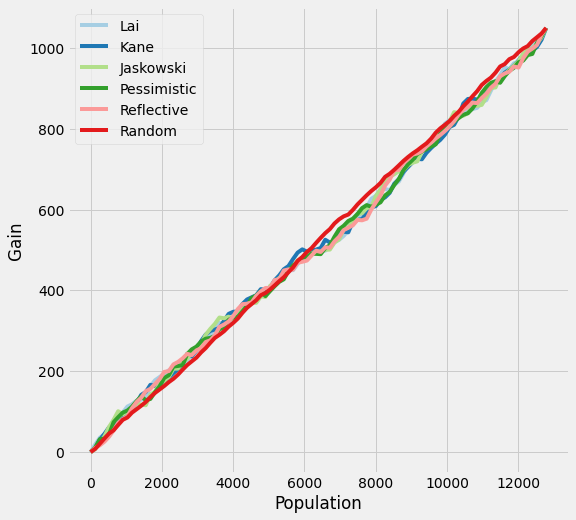

In [23]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest CTS': forest_CTS.flatten(), 'Uplift Random Forest KL': forest_KL.flatten(),
                   'Uplift Random Forest ED': forest_ED.flatten(), 'Uplift Random Forest Chi': forest_Chi.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [24]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.484406
SoloModel treat interaction    0.478585
Random                         0.497332
dtype: float64
BaseTLearner               0.474329
TwoModels control first    0.481640
TwoModels treat first      0.473307
Random                     0.497332
dtype: float64
BaseXLearner    0.498902
BaseRLearner    0.490599
Random          0.497332
dtype: float64
Uplift Random Forest CTS    0.514356
Uplift Random Forest KL     0.492291
Uplift Random Forest ED     0.521108
Uplift Random Forest Chi    0.467640
Random                      0.497332
dtype: float64
Lai            0.491850
Kane           0.491836
Jaskowski      0.492061
Pessimistic    0.489587
Reflective     0.490706
Random         0.497332
dtype: float64


## Womens campaign

In [25]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2, frac=0.7)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [26]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_CTS = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='KL')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_KL = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='ED')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_ED = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='Chi')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_Chi = uplift_model.predict(X=X_test)

In [27]:
### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

In [28]:
### sklift

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)


## Visualization

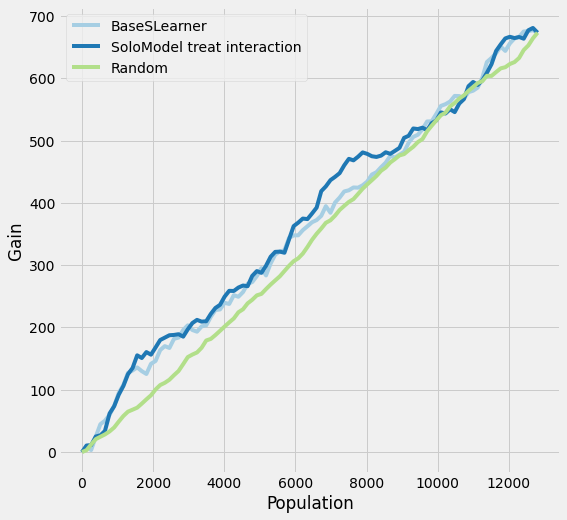

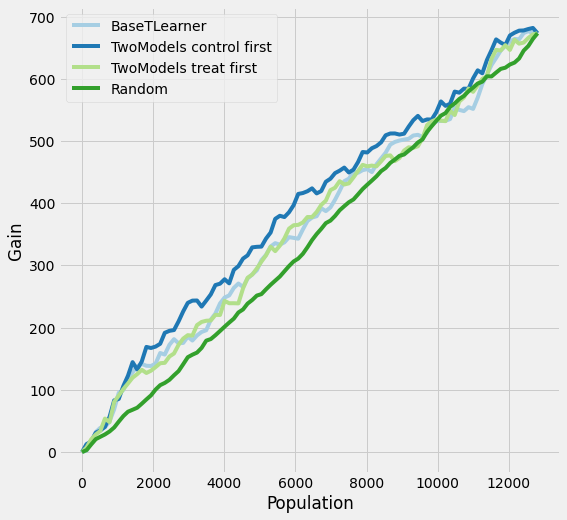

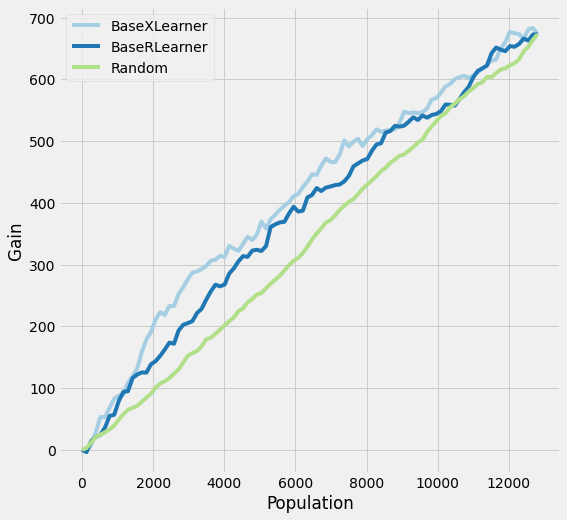

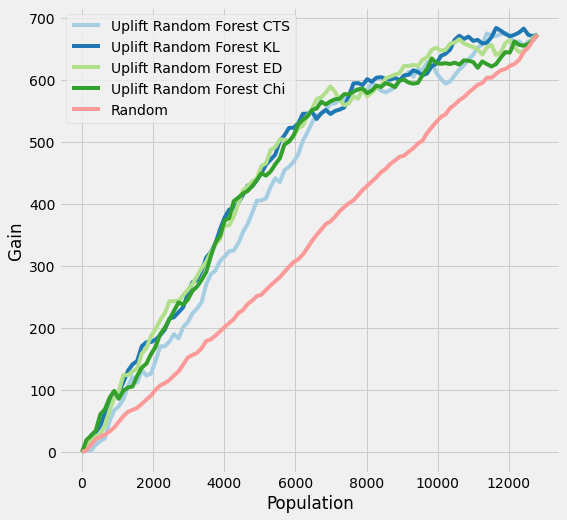

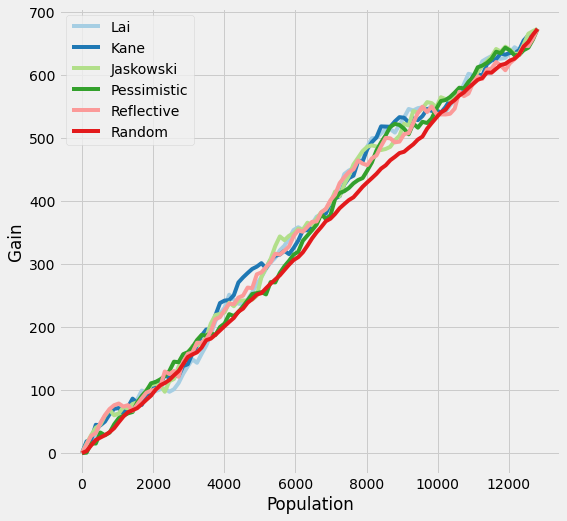

In [29]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest CTS': forest_CTS.flatten(), 'Uplift Random Forest KL': forest_KL.flatten(),
                   'Uplift Random Forest ED': forest_ED.flatten(), 'Uplift Random Forest Chi': forest_Chi.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [30]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.535237
SoloModel treat interaction    0.550045
Random                         0.496904
dtype: float64
BaseTLearner               0.537428
TwoModels control first    0.575811
TwoModels treat first      0.537450
Random                     0.496904
dtype: float64
BaseXLearner    0.603324
BaseRLearner    0.563326
Random          0.496904
dtype: float64
Uplift Random Forest CTS    0.637600
Uplift Random Forest KL     0.675875
Uplift Random Forest ED     0.674352
Uplift Random Forest Chi    0.659967
Random                      0.496904
dtype: float64
Lai            0.527486
Kane           0.531646
Jaskowski      0.529836
Pessimistic    0.515630
Reflective     0.523944
Random         0.496904
dtype: float64
